In [1]:
# MIT License

# Copyright (c) 2020 Daniel Bourke

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

In [2]:
# GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

# Project 1: Food Vision: Transfer Learning and Fine Tuning

# Get workspace ready

In [3]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.Data pre-processing

## Import and explore datasets

In [6]:
import tensorflow_datasets as tfds

In [7]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [8]:
ls

sample_data/


In [9]:
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"], shuffle_files=False, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.1UQFJB_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.1UQFJB_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [83]:
test_data_tmp = test_data

In [10]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
train_one_sample = train_data.take(1)

In [13]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        


In [15]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

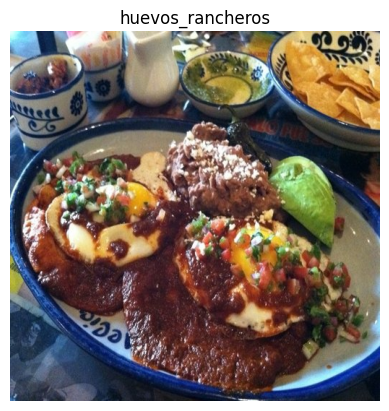

In [16]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions

In [17]:
def preprocess_img(image, label, img_shape=224):

  image = tf.image.resize(image, [img_shape, img_shape])
  image = image/255.
  return tf.cast(image, tf.float32), label

In [18]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[0.9045418  0.99467784 0.9843137 ]
  [0.87450975 0.9998999  0.9889956 ]
  [0.81202483 1.         0.9818327 ]
  ...
  [0.5516191  0.5079419  0.47538933]
  [0.4750693  0.4520202  0.45864302]
  [0.32922992 0.32580858 0.35151908]]

 [[0.8685274  0.997559   0.9934574 ]
  [0.84121644 1.         0.9957783 ]
  [0.77809125 0.99837935 0.98811525]
  ...
  [0.81828696 0.76792717 0.6800323 ]
  [0.7726689  0.745518   0.68561417]
  [0.6883936  0.6730074  0.63221115]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


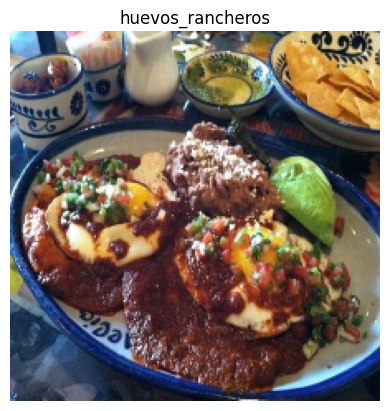

In [19]:
plt.imshow(preprocessed_img)
plt.title(class_names[label])
plt.axis(False);

## Batch and prepare datasets

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [21]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [23]:
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [25]:
from tensorflow.keras import layers

rescale = layers.Rescaling(1)
test_data1 = test_data.map(lambda x, y: (rescale(x), y))

In [26]:
train_data, test_data, test_data1

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [27]:
len(train_data), len(test_data)

(2368, 790)

## Create modelling callbacks

In [28]:
checkpoint_path = "model_checkpoints/cp.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [29]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [30]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# 2.Building a model

In [31]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

<ipython-input-31-307066aa40e4>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,387,365 (9.11 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
mobilenetv2_1.00_224 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [34]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
Conv1 False float32 <DTypePolicy "mixed_float16">
bn_Conv1 False float32 <DTypePolicy "mixed_float16">
Conv1_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_BN False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_project False float32 <DTypePolicy "mixed_float16">
expanded_conv_project_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand False float32 <DTypePolicy "mixed_float16">
block_1_expand_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand_relu False float32 <DTypePolicy "mixed_float16">
block_1_pad False float32 <DTypePolicy "mixed_float16">
block_1_depthwise False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_BN False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_relu False float32 <DTypePolicy "mixed_float16">
bloc

## Build a feature extraction model using transfer learning

In [35]:
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=1,                # 3
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)))

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 16450s 7s/step - accuracy: 0.3812 - loss: 2.6124 - val_accuracy: 0.5633 - val_loss: 1.6385


In [36]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

551/790 ━━━━━━━━━━━━━━━━━━━━ 26:19 7s/step - accuracy: 0.5602 - loss: 1.6692

KeyboardInterrupt: 

In [42]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

In [43]:
def pred_and_plot(model, filename, class_names):

  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

In [44]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg           ###############
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


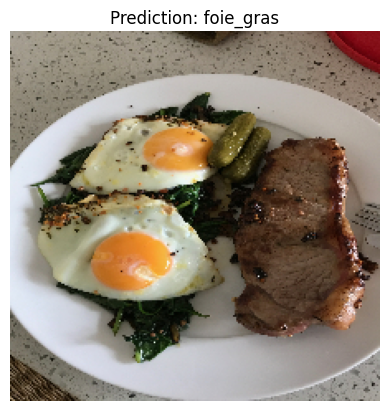

In [45]:
pred_and_plot(model, "03-steak.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


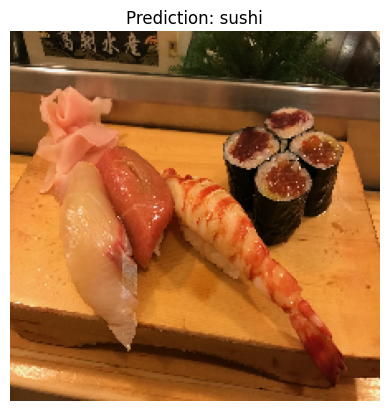

In [46]:
pred_and_plot(model, "03-sushi.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


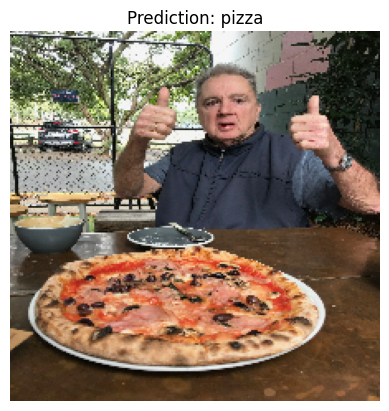

In [47]:
pred_and_plot(model, "03-pizza-dad.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


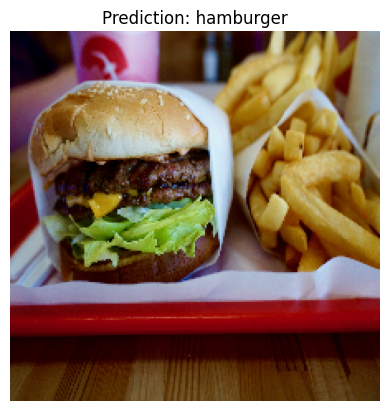

In [48]:
pred_and_plot(model, "03-hamburger.jpeg", class_names)

In [49]:
save_dir = "07_MobileNetV2_feature_extract_model_mixed_precision.keras"
model.save(save_dir)

In [50]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [51]:
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
Conv1 False float32 <DTypePolicy "mixed_float16">
bn_Conv1 False float32 <DTypePolicy "mixed_float16">
Conv1_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_BN False float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_relu False float32 <DTypePolicy "mixed_float16">
expanded_conv_project False float32 <DTypePolicy "mixed_float16">
expanded_conv_project_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand False float32 <DTypePolicy "mixed_float16">
block_1_expand_BN False float32 <DTypePolicy "mixed_float16">
block_1_expand_relu False float32 <DTypePolicy "mixed_float16">
block_1_pad False float32 <DTypePolicy "mixed_float16">
block_1_depthwise False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_BN False float32 <DTypePolicy "mixed_float16">
block_1_depthwise_relu False float32 <DTypePolicy "mixed_float16">
block

In [52]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

  2/790 ━━━━━━━━━━━━━━━━━━━━ 1:32:21 7s/step - accuracy: 0.5703 - loss: 1.5463 

KeyboardInterrupt: 

In [53]:
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

NameError: name 'results_feature_extract_model' is not defined

## Fine-tune the feature extraction model

In [54]:
loaded_gs_model = tf.keras.models.load_model("07_MobileNetV2_feature_extract_model_mixed_precision.keras")

In [55]:
loaded_gs_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,646,133 (10.09 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [56]:
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

  2/790 ━━━━━━━━━━━━━━━━━━━━ 1:20:07 6s/step - accuracy: 0.5703 - loss: 1.5463 

KeyboardInterrupt: 

In [58]:
for layer in loaded_gs_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
mobilenetv2_1.00_224 True float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [59]:
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
Conv1 True float32 <DTypePolicy "mixed_float16">
bn_Conv1 True float32 <DTypePolicy "mixed_float16">
Conv1_relu True float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise True float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_BN True float32 <DTypePolicy "mixed_float16">
expanded_conv_depthwise_relu True float32 <DTypePolicy "mixed_float16">
expanded_conv_project True float32 <DTypePolicy "mixed_float16">
expanded_conv_project_BN True float32 <DTypePolicy "mixed_float16">
block_1_expand True float32 <DTypePolicy "mixed_float16">
block_1_expand_BN True float32 <DTypePolicy "mixed_float16">
block_1_expand_relu True float32 <DTypePolicy "mixed_float16">
block_1_pad True float32 <DTypePolicy "mixed_float16">
block_1_depthwise True float32 <DTypePolicy "mixed_float16">
block_1_depthwise_BN True float32 <DTypePolicy "mixed_float16">
block_1_depthwise_relu True float32 <DTypePolicy "mixed_float16">
block_1_project True

In [63]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
checkpoint_path = "fine_tune_checkpoints/cp.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss")

In [64]:
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])

# 3.Training a model

## Train the model using trained dataset

In [65]:
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=1,                         # 5
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)))

  10/2368 ━━━━━━━━━━━━━━━━━━━━ 77:19:50 118s/step - accuracy: 0.2523 - loss: 3.2232

KeyboardInterrupt: 

In [66]:
results_fine_tuning_model = loaded_gs_model.evaluate(test_data)
results_fine_tuning_model

 39/790 ━━━━━━━━━━━━━━━━━━━━ 1:22:27 7s/step - accuracy: 0.5414 - loss: 1.7671

KeyboardInterrupt: 

In [67]:
save_dir2 = "07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras"
loaded_gs_model.save(save_dir2)

In [68]:
loaded_gs_model.save("07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras")

In [69]:
loaded_fine_tuned_gs_model = tf.keras.models.load_model("07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras")

In [70]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

  1/790 ━━━━━━━━━━━━━━━━━━━━ 2:16:01 10s/step - accuracy: 0.5625 - loss: 1.6300

KeyboardInterrupt: 

In [71]:
assert np.isclose(results_fine_tuning_model, results_downloaded_fine_tuned_gs_model).all()

NameError: name 'results_fine_tuning_model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


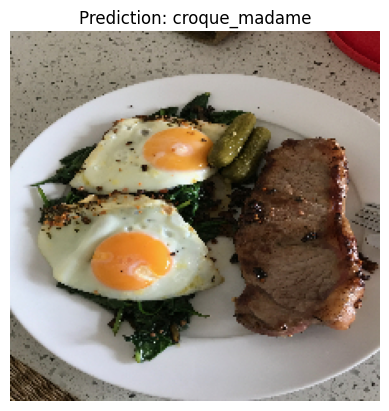

In [72]:
pred_and_plot(loaded_gs_model, "03-steak.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


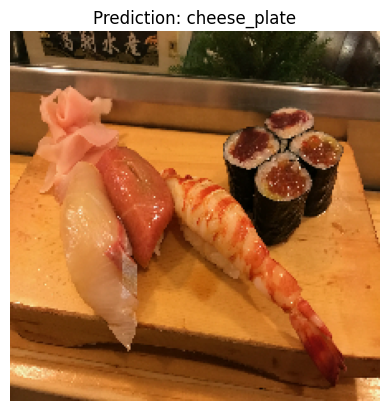

In [73]:
pred_and_plot(loaded_gs_model, "03-sushi.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


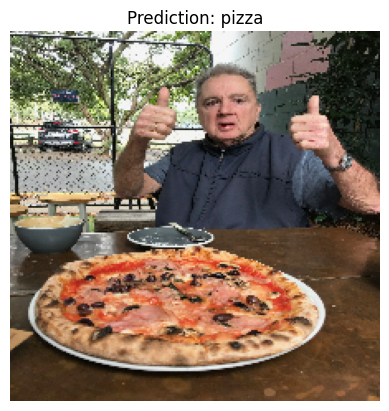

In [74]:
pred_and_plot(loaded_gs_model, "03-pizza-dad.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


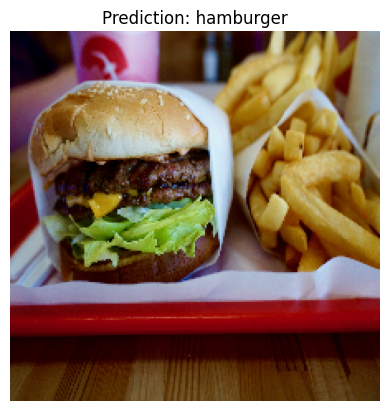

In [75]:
pred_and_plot(loaded_gs_model, "03-hamburger.jpeg", class_names)

# 4.Model evaluation

In [76]:
save_dir3 = "07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras"
loaded_fine_tuned_gs_model3 = tf.keras.models.load_model(save_dir3)

In [77]:
loaded_fine_tuned_gs_model3 = tf.keras.models.load_model("07_MobileNetV2_fine_tuned_101_classes_mixed_precision.keras")

## Make predictions on food images using validation dataset

In [82]:
pred_probs = loaded_fine_tuned_gs_model3.predict(test_data, verbose=1)
pred_probs

  1/790 ━━━━━━━━━━━━━━━━━━━━ 1:39:55 8s/step

KeyboardInterrupt: 

In [79]:
pred_probs.shape

NameError: name 'pred_probs' is not defined

In [80]:
sum(pred_probs[0])

NameError: name 'pred_probs' is not defined

In [81]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

NameError: name 'pred_probs' is not defined

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

In [84]:
test_one_sample = test_data_tmp.take(1)

In [85]:
test_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [86]:
for image1, label1 in test_one_sample:
  print(f"""
  Image shape: {image1.shape}
  Image dtype: {image1.dtype}
  Target class from Food101 (tensor form): {label1}
  # Class name (str form): {class_names[label1.numpy()]}
        """)

TypeError: only integer scalar arrays can be converted to a scalar index

In [87]:
def one_hot_encode_labels(image, label):

  num_classes = len(class_names)
  one_hot_label = tf.one_hot(label, depth=num_classes, dtype=tf.int64)
  return image, one_hot_label
test_data1 = test_data1.map(one_hot_encode_labels)

In [88]:
y_labels = []
for images, labels in test_data1.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[np.int64(29),
 np.int64(81),
 np.int64(91),
 np.int64(53),
 np.int64(97),
 np.int64(97),
 np.int64(10),
 np.int64(31),
 np.int64(3),
 np.int64(100)]

In [91]:
len(y_labels), pred_classes.shape

NameError: name 'pred_classes' is not defined

## Evaluate for precision, recall, and f1 scores

In [90]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

NameError: name 'pred_classes' is not defined

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

## Create a confusion matrix, and find the most wrong predictions

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

In [ ]:
pred_df.head()

In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

# 5.Deployment

## Make predictions on custom food images with prediction probabilities

In [ ]:
custom_food_images1 = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images1

In [ ]:
from matplotlib import pyplot as plt

i = 1
fig = plt.figure(figsize=(15, 7))

for img in custom_food_images1:
  img = load_and_prep_image(img, scale=True)
  if i == 1:
    class_name = 'sushi'
  elif i == 2:
    class_name = 'pizza'
  else:
    class_name = 'chicken_wings'

  pred_prob = loaded_fine_tuned_gs_model3.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.subplot(1, 3, i)
  plt.imshow(img)

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)
  i = i +1